In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from pathlib import Path
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import shutil
import numpy as np

In [2]:
# windows 环境下长路径问题
root = r"\\?\D:\Learning\Data\dataset\Facial-Feature-Extraction-Dataset"
train_dir = os.path.join(root, 'train')
test_dir = os.path.join(root, 'test')
valid_dir = os.path.join(root, 'valid')

In [3]:
train_images_dir = os.path.join(train_dir, 'images')
train_labels_dir = os.path.join(train_dir, 'labels')
train_image_files = sorted(os.listdir(train_images_dir))  # 按名称排序，确保图像与标签一一对应
train_label_files = sorted(os.listdir(train_labels_dir))  # 同样排序标签文件

# 确保两者文件数量相同
assert len(train_image_files) == len(train_label_files), "图像和标签文件数量不匹配！"
print(len(train_image_files))

457


In [4]:
test_images_dir = os.path.join(test_dir, 'images')
test_labels_dir = os.path.join(test_dir, 'labels')
test_image_files = sorted(os.listdir(test_images_dir))  # 按名称排序，确保图像与标签一一对应
test_label_files = sorted(os.listdir(test_labels_dir))  # 同样排序标签文件

# 确保两者文件数量相同
assert len(test_image_files) == len(test_label_files), "图像和标签文件数量不匹配！"
print(len(test_image_files))

66


In [5]:
valid_images_dir = os.path.join(valid_dir, 'images')
valid_labels_dir = os.path.join(valid_dir, 'labels')
valid_image_files = sorted(os.listdir(valid_images_dir))  # 按名称排序，确保图像与标签一一对应
valid_label_files = sorted(os.listdir(valid_labels_dir))  # 同样排序标签文件

# 确保两者文件数量相同
assert len(valid_image_files) == len(valid_label_files), "图像和标签文件数量不匹配！"
print(len(valid_image_files))

126


In [6]:
class Visualizer:
    def __init__(self):
        self.colors = [
            (255, 0, 0),  # 红色
            (0, 255, 0),  # 绿色
            (0, 0, 255),  # 蓝色
            (255, 255, 0),  # 黄色
            (0, 255, 255),  # 青色
        ]
        
    def __extract_bboxes(self, labels):
        bboxes = []
        for label in labels:
            # 每行按空格分割
            parts = label.split()

            # 将每个值转换成相应的类型（整数和浮动值）
            if (type(parts[0]) == int):
                cls = int(parts[0])
            else:
                cls = round(float(parts[0]))
            x_center = float(parts[1])  # 中心点 x 坐标
            y_center = float(parts[2])  # 中心点 y 坐标
            width = float(parts[3])  # 宽度
            height = float(parts[4])  # 高度

            # 将每个框的信息存储为元组
            box = (cls, x_center, y_center, width, height)

            # 将该框加入到boxes列表中
            bboxes.append(box)
        return bboxes

    def show_bbox(self, image_path, label_path):
        # 打开并读取文件
        with open(label_path, "r") as file:
            content = file.read()  # 读取整个文件内容
        labels = content.strip().split("\n")
        bboxes = self.__extract_bboxes(labels)

        image = cv2.imread(image_path)
        h, w, _ = image.shape
        
        # 将 BGR 图像转换为 RGB 图像，因为 OpenCV 使用 BGR 格式，而 matplotlib 使用 RGB 格式
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 遍历 boxes 绘制矩形框
        for i, (_, cx, cy, width, height) in enumerate(bboxes):
            # 将相对坐标转换为绝对坐标
            x1 = int((cx - width / 2) * w)
            y1 = int((cy - height / 2) * h)
            x2 = int((cx + width / 2) * w)
            y2 = int((cy + height / 2) * h)

            # 使用颜色绘制框
            color = self.colors[i % len(self.colors)]  # 循环使用颜色
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)  # 2 是边框的宽度

        # 使用 matplotlib 显示图像
        plt.figure(figsize=(10, 10))  # 可以调整图像显示大小
        plt.imshow(image)
        plt.axis('off')  # 关闭坐标轴
        plt.show()
        

    def show_head(self, images_dir, labels_dir, num=9):
        images_dir = Path(images_dir)
        images = sorted(images_dir.iterdir())[:num]
        labels_dir = Path(labels_dir)
        labels = sorted(labels_dir.iterdir())[:num]
        
        num_cols = 3  # 每行显示 3 张图片
        num_rows = (num + num_cols - 1) // num_cols  # 计算需要几行
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
        axes = axes.flatten()  # 将 axes 展平，便于迭代
        
        colors = [(r / 255, g / 255, b / 255) for r, g, b in self.colors]
        
        for i, (image_path, label_path) in enumerate(zip(images, labels)):
            # 打开图片
            img = Image.open(image_path)
            img_w, img_h = img.size  # 获取图片的宽高
            axes[i].imshow(img)
            
            # 读取并解析标签文件
            if label_path.exists():
                with open(label_path, "r") as file:
                    labels = file.read().strip().split("\n")
                bboxes = self.__extract_bboxes(labels)
                
                for j, box in enumerate(bboxes):
                    (cls, cx, cy, width, height) = box
                    x1 = (cx - width / 2) * img_w
                    y1 = (cy - height / 2) * img_h
                    rect = plt.Rectangle(
                        (x1, y1), width * img_w, height * img_h,
                        linewidth=1,
                        edgecolor=colors[j % len(colors)],  # 使用循环颜色逻辑
                        facecolor='none'
                    )
                    axes[i].add_patch(rect)
        
        axes[i].axis('off')  # 去掉坐标轴
        axes[i].set_title(f"Image {i+1}")  # 设置标题
            
        # 隐藏多余的子图
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.show()
                

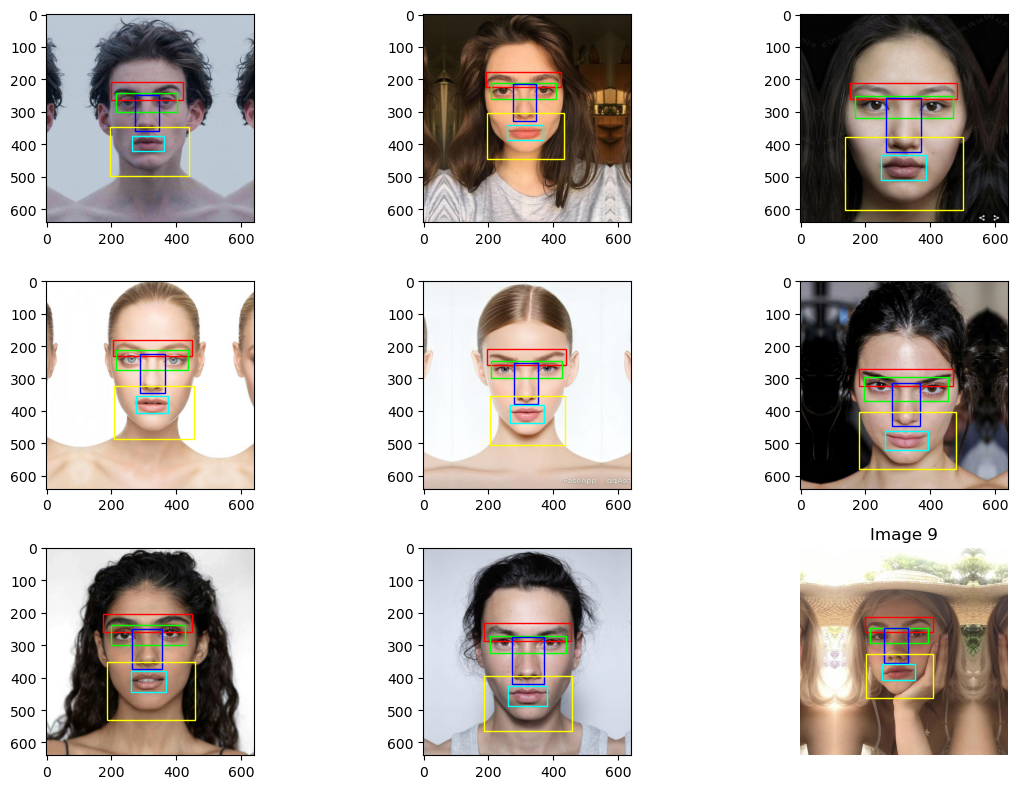

In [7]:
visualizer = Visualizer()
visualizer.show_head(train_images_dir, train_labels_dir, 9)

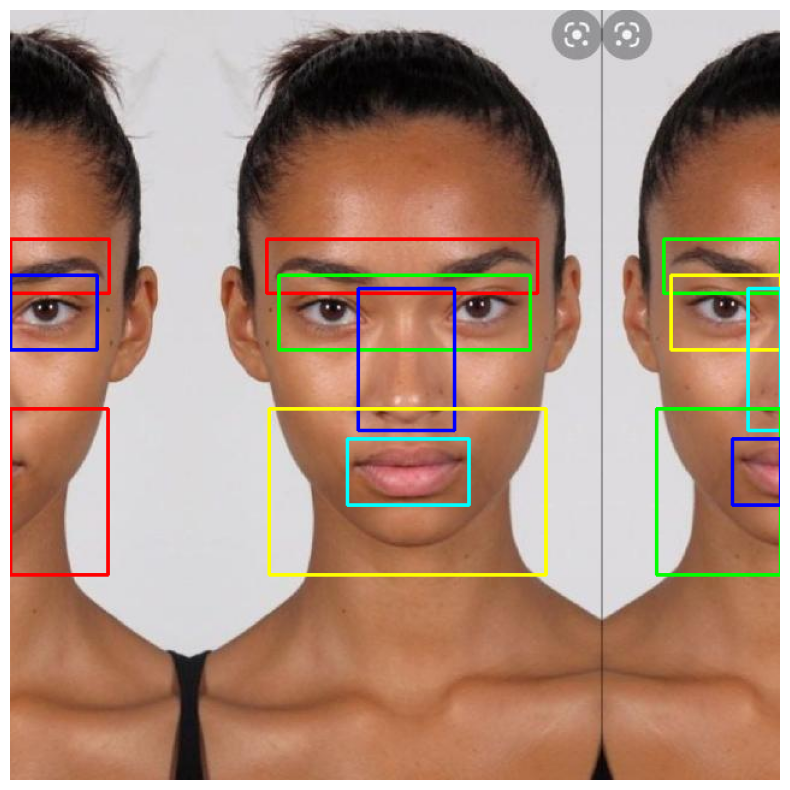

In [8]:
triple_face_img_path = os.path.join(train_images_dir, '_-2-_jpeg.rf.f4ef9d470e77fa6dda4bd120f2e580d8.jpg')
triple_face_label_path = os.path.join(train_labels_dir, '_-2-_jpeg.rf.f4ef9d470e77fa6dda4bd120f2e580d8.txt')
visualizer.show_bbox(triple_face_img_path, triple_face_label_path)

In [9]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, 5 * 5)  # 5个关键点，每个关键点5个输出（类别ID和4个坐标）
)
model

d:\DevKits\Anaconda3\envs\dl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DevKits\Anaconda3\envs\dl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
class BoundingBoxModel(nn.Module):
    def __init__(self, num_organ=5):  # 假设每张图像有5个器官
        super(BoundingBoxModel, self).__init__()
        
        # 加载预训练的 ResNet18
        self.resnet = models.resnet18(pretrained=True)
        
        # 替换全连接层，输出每个器官的4个坐标（x_center, y_center, width, height）
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_organ * 4)

    def forward(self, x):
        return self.resnet(x)

In [11]:
class BoundingBoxDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        """
        Args:
            images_dir (str): 图像文件夹路径
            labels_dir (str): 标签文件夹路径
            transform (callable, optional): 图像的转换操作
        """
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform

        # 获取图像文件夹中的所有图像文件
        self.image_paths = [os.path.join(images_dir, fname) for fname in os.listdir(images_dir) if fname.endswith('.jpg')]  # 假设图像为 jpg 格式
        self.label_paths = [os.path.join(labels_dir, fname.replace('.jpg', '.txt')) for fname in os.listdir(images_dir) if fname.endswith('.jpg')]  # 假设标签为 txt 格式

    def __len__(self):
        # 返回数据集的大小
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 获取图像和标签
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # 读取图像
        image = Image.open(image_path).convert('RGB')

        # 读取标签文件
        with open(label_path, 'r') as f:
            labels = f.readlines()

        boxes = []
        for label in labels:
            parts = label.strip().split()
            cls = int(parts[0])  # 类别
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            boxes.append([cls, x_center, y_center, width, height])

        # 应用任何传入的变换
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        # TODO 临时处理，只取前5个框
        if len(boxes) >= 5:
            boxes = boxes[:5]
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        
        return image, boxes

In [12]:
transform = transforms.Compose([
    transforms.ToTensor()  # 转换为 Tensor
])

train_dataset = BoundingBoxDataset(train_images_dir, train_labels_dir)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
for epoch in range(30):
    model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        # 调整outputs的shape
        outputs = outputs.view(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.010943630710244179
Epoch 2, Loss: 0.005244642961770296
Epoch 3, Loss: 0.003833753289654851
Epoch 4, Loss: 0.0039109778590500355
Epoch 5, Loss: 0.004107362125068903
Epoch 6, Loss: 0.005225773900747299
Epoch 7, Loss: 0.004902744200080633
Epoch 8, Loss: 0.0049257054924964905
Epoch 9, Loss: 0.004748458042740822
Epoch 10, Loss: 0.004963319282978773
Epoch 11, Loss: 0.002589177107438445
Epoch 12, Loss: 0.0030636172741651535
Epoch 13, Loss: 0.0028567942790687084
Epoch 14, Loss: 0.0029886020347476006
Epoch 15, Loss: 0.0028199392836540937
Epoch 16, Loss: 0.0020704027265310287
Epoch 17, Loss: 0.0018513486720621586
Epoch 18, Loss: 0.0017871952150017023
Epoch 19, Loss: 0.0017219719011336565
Epoch 20, Loss: 0.0018817057134583592
Epoch 21, Loss: 0.0015112271066755056
Epoch 22, Loss: 0.0014733393909409642
Epoch 23, Loss: 0.00139174098148942
Epoch 24, Loss: 0.001392227946780622
Epoch 25, Loss: 0.0013720608549192548
Epoch 26, Loss: 0.001278436160646379
Epoch 27, Loss: 0.0012710945447906

In [16]:
def save_labels(labels, save_path):
    # 将 outputs 转换为列表
    outputs_list = labels.tolist()

    # 写入文件
    with open(save_path, 'w') as f:
        for sample in outputs_list:
            for label in sample:
                # 将每个标签的值转换为字符串，并用空格分隔
                label_str = ' '.join(map(str, label))
                f.write(label_str + '\n')

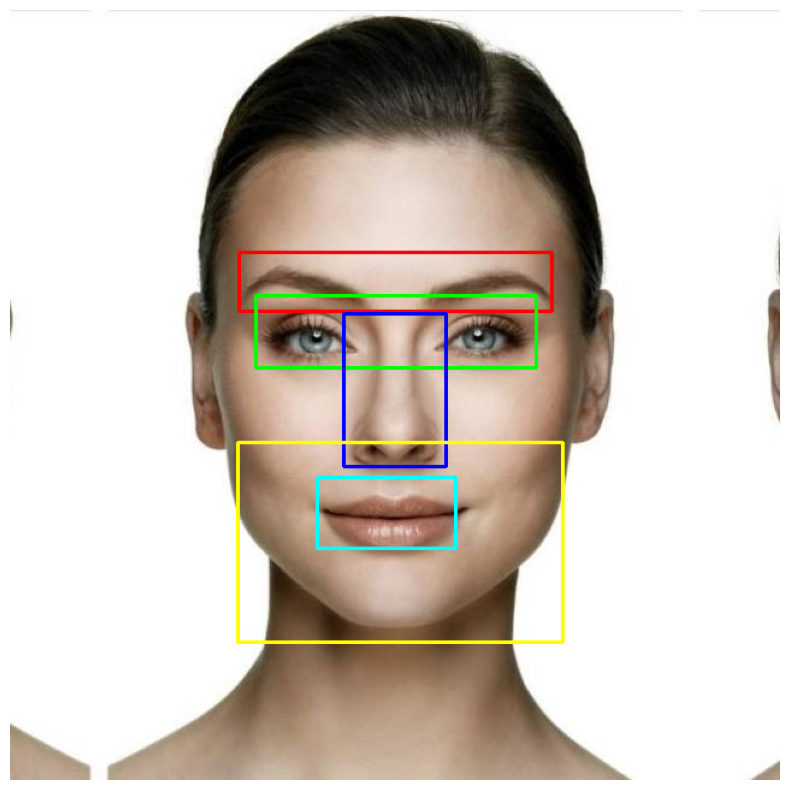

In [35]:
random_index = np.random.randint(len(os.listdir(test_images_dir)))
test_img_to_show = os.path.join(test_images_dir, os.listdir(test_images_dir)[random_index])
shutil.copy(test_img_to_show, 'test_img_to_show.jpg')
img = transform(Image.open('test_img_to_show.jpg'))
img = img.unsqueeze(0)
img = img.to(device)
model.eval()
outputs = model(img)
outputs = outputs.view(1, 5, 5)
save_labels(outputs, 'test_labels_to_show.txt')
visualizer.show_bbox(test_img_to_show, 'test_labels_to_show.txt')
# 这个效果比较好，实际上并非所有都能有这样的效果